# API Pull

In [1]:
# Dependencies

import pandas as pd
import requests
from scipy.stats import linregress
import matplotlib.pyplot as plt
import numpy as np


# Import the OpenWeatherMap API key

from config import api_key


In [2]:
# Define parameters

lat = 41.9
lon = 87.6

# Set the API base URL

url = f'https://api.openweathermap.org/data/3.0/onecall?lat={lat}&lon={lon}&units=metric&appid={api_key}'

chicago_current_weather = requests.get(url).json()

chicago_current_weather

{'lat': 41.9,
 'lon': 87.6,
 'timezone': 'Asia/Shanghai',
 'timezone_offset': 28800,
 'current': {'dt': 1733937209,
  'sunrise': 1733966892,
  'sunset': 1733999924,
  'temp': -11.74,
  'feels_like': -11.74,
  'pressure': 1047,
  'humidity': 83,
  'dew_point': -13.79,
  'uvi': 0,
  'clouds': 35,
  'visibility': 10000,
  'wind_speed': 0.99,
  'wind_deg': 106,
  'wind_gust': 0.96,
  'weather': [{'id': 802,
    'main': 'Clouds',
    'description': 'scattered clouds',
    'icon': '03n'}]},
 'minutely': [{'dt': 1733937240, 'precipitation': 0},
  {'dt': 1733937300, 'precipitation': 0},
  {'dt': 1733937360, 'precipitation': 0},
  {'dt': 1733937420, 'precipitation': 0},
  {'dt': 1733937480, 'precipitation': 0},
  {'dt': 1733937540, 'precipitation': 0},
  {'dt': 1733937600, 'precipitation': 0},
  {'dt': 1733937660, 'precipitation': 0},
  {'dt': 1733937720, 'precipitation': 0},
  {'dt': 1733937780, 'precipitation': 0},
  {'dt': 1733937840, 'precipitation': 0},
  {'dt': 1733937900, 'precipitation'

In [3]:
# Load the bikeshare dataset (replace with your actual file path)

data = pd.read_csv('../output/merged_weather_bike_data.csv')

# Metrics to Predict data by

data = data[['temp', 'feels_like', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'wind_gust', 'ride_id']]

# Count rides grouped by weather-related features

base_data = data.groupby(['temp', 'feels_like', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'wind_gust'], as_index=False)['ride_id'].count()
base_data.rename(columns={'ride_id': 'ride_count'}, inplace=True)

base_data

,temp,feels_like,pressure,humidity,wind_speed,wind_deg,wind_gust,ride_count
0,-22.36,-29.36,1013,76,14.31,282,17.88,2
1,-22.31,-29.31,1013,76,15.20,280,17.88,2
2,-21.34,-28.34,1025,70,9.30,300,0.00,1
3,-20.78,-27.78,1027,69,8.20,300,0.00,1
4,-20.53,-27.53,1014,73,15.65,272,19.67,1
...,...,...,...,...,...,...,...,...
19137,37.34,44.34,1010,49,6.69,250,11.32,113
19138,37.47,44.47,1007,51,8.23,240,11.83,85
19139,38.05,45.05,1008,47,6.69,220,11.32,86
19140,38.13,45.13,1011,46,3.58,295,5.81,107


In [9]:
# Load the bikeshare weather dataset
data = pd.read_csv('../output/merged_weather_bike_data.csv')

# Convert and extract month from Weather API JSON dt and limit applicable data to the same month
applicable_month = pd.to_datetime(chicago_current_weather['hourly'][0]['dt'], unit='s').month
applicable_data = data.loc[data['start_month'] == applicable_month, :]

# Metrics to Predict data by
applicable_data = applicable_data[['temp', 'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity', 'ride_id']]

# Count rides grouped by weather-related features
base_data = applicable_data.groupby(
    ['temp', 'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity'], as_index=False)['ride_id'].count()
base_data.rename(columns={'ride_id': 'ride_count'}, inplace=True)

# Define sampled columns and results list
sampled_columns = ['temp', 'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity']
predicted_metrics = []

# Loop through the hourly weather data
for hour in chicago_current_weather['hourly']:
    # Define the datetime in question
    dt = pd.to_datetime(hour['dt'], unit='s')

    # Loop through each metric and predict bikeshare usage
    for metric in sampled_columns:
        # Prepare training data
        X = base_data[[metric]]
        y = base_data['ride_count']

        # Train a simple regression model using linregress
        slope, intercept, r_value, p_value, std_err = linregress(X[metric], y)

        # Calculate R-squared
        r_squared = r_value ** 2

        # Predict ride count using linregress formula (y = mx + b)
        predicted_ride_count = slope * hour.get(metric, 0) + intercept

        # Add prediction and R-squared value to results
        predicted_metrics.append({
            'Datetime': dt,
            'Metric': metric,
            'Value': max(0, int(predicted_ride_count)),
            'R_squared': round(r_squared, 4)  # Round R-squared for readability
        })

# Convert the list of dictionaries into a DataFrame
predicted_ride_df = pd.DataFrame(predicted_metrics)

# Display the updated DataFrame
predicted_ride_df

,Datetime,Metric,Value,R_squared
0,2024-12-11 17:00:00,temp,2,0.1134
1,2024-12-11 17:00:00,feels_like,8,0.1113
2,2024-12-11 17:00:00,temp_min,13,0.1206
3,2024-12-11 17:00:00,temp_max,12,0.1073
4,2024-12-11 17:00:00,pressure,16,0.0031
...,...,...,...,...
283,2024-12-13 16:00:00,feels_like,4,0.1113
284,2024-12-13 16:00:00,temp_min,13,0.1206
285,2024-12-13 16:00:00,temp_max,12,0.1073
286,2024-12-13 16:00:00,pressure,16,0.0031


In [10]:
# A prediction data series by the hour with R^2 values

prediction_series = predicted_ride_df.groupby("Datetime").agg({"Value": "mean", "R_squared": "mean"}).reset_index().rename(columns={"Value": "Predicted Ride Count", "R_squared": "Mean R_squared"})

# Metrics-by-the-hour table with R^2 values
metrics_table_values = predicted_ride_df.pivot(index="Datetime", columns="Metric", values="Value").reset_index()
metrics_table_r_squared = predicted_ride_df.pivot(index="Datetime", columns="Metric", values="R_squared").reset_index()

# Merge value and R^2 tables, adding suffixes for clarity
metrics_table = metrics_table_values.merge(
    metrics_table_r_squared,
    on="Datetime",
    suffixes=("_Value", "_R_squared")
)

# Ensure Predicted Ride Count is an integer
prediction_series["Predicted Ride Count"] = prediction_series["Predicted Ride Count"].astype(int)

# Display the updated tables
print("Clean Representative Ride Count Table with R-squared:")
display(prediction_series.head())
display(prediction_series.tail())

print("Metrics-by-Time Table with R-squared:")
display(metrics_table.head())
display(metrics_table.tail())


Clean Representative Ride Count Table with R-squared:


,Datetime,Predicted Ride Count,Mean R_squared
0,2024-12-11 17:00:00,10,0.09085
1,2024-12-11 18:00:00,10,0.09085
2,2024-12-11 19:00:00,9,0.09085
3,2024-12-11 20:00:00,9,0.09085
4,2024-12-11 21:00:00,9,0.09085


,Datetime,Predicted Ride Count,Mean R_squared
43,2024-12-13 12:00:00,9,0.09085
44,2024-12-13 13:00:00,9,0.09085
45,2024-12-13 14:00:00,9,0.09085
46,2024-12-13 15:00:00,8,0.09085
47,2024-12-13 16:00:00,9,0.09085


Metrics-by-Time Table with R-squared:


Metric,Datetime,feels_like_Value,humidity_Value,pressure_Value,temp_Value,temp_max_Value,temp_min_Value,feels_like_R_squared,humidity_R_squared,pressure_R_squared,temp_R_squared,temp_max_R_squared,temp_min_R_squared
0,2024-12-11 17:00:00,8,10,16,2,12,13,0.1113,0.0894,0.0031,0.1134,0.1073,0.1206
1,2024-12-11 18:00:00,8,10,16,2,12,13,0.1113,0.0894,0.0031,0.1134,0.1073,0.1206
2,2024-12-11 19:00:00,7,9,16,2,12,13,0.1113,0.0894,0.0031,0.1134,0.1073,0.1206
3,2024-12-11 20:00:00,7,9,16,2,12,13,0.1113,0.0894,0.0031,0.1134,0.1073,0.1206
4,2024-12-11 21:00:00,5,8,16,2,12,13,0.1113,0.0894,0.0031,0.1134,0.1073,0.1206


Metric,Datetime,feels_like_Value,humidity_Value,pressure_Value,temp_Value,temp_max_Value,temp_min_Value,feels_like_R_squared,humidity_R_squared,pressure_R_squared,temp_R_squared,temp_max_R_squared,temp_min_R_squared
43,2024-12-13 12:00:00,4,7,16,2,12,13,0.1113,0.0894,0.0031,0.1134,0.1073,0.1206
44,2024-12-13 13:00:00,4,7,16,2,12,13,0.1113,0.0894,0.0031,0.1134,0.1073,0.1206
45,2024-12-13 14:00:00,4,7,16,2,12,13,0.1113,0.0894,0.0031,0.1134,0.1073,0.1206
46,2024-12-13 15:00:00,4,7,16,1,12,13,0.1113,0.0894,0.0031,0.1134,0.1073,0.1206
47,2024-12-13 16:00:00,4,8,16,1,12,13,0.1113,0.0894,0.0031,0.1134,0.1073,0.1206


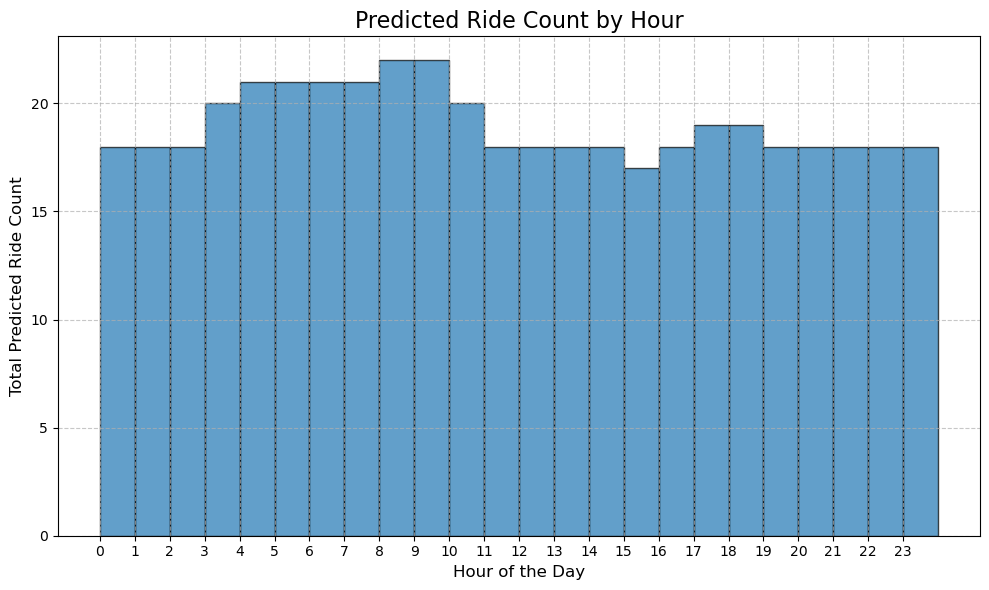

In [7]:
# Extract hour from datetime for histogram
prediction_series["Hour"] = prediction_series["Datetime"].dt.hour

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(prediction_series["Hour"], bins=range(0, 25), weights=prediction_series["Predicted Ride Count"], edgecolor="black", alpha=0.7)

# Add titles and labels
plt.title("Predicted Ride Count by Hour", fontsize=16)
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Total Predicted Ride Count", fontsize=12)
plt.xticks(range(0, 24, 1))
plt.grid(visible=True, linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

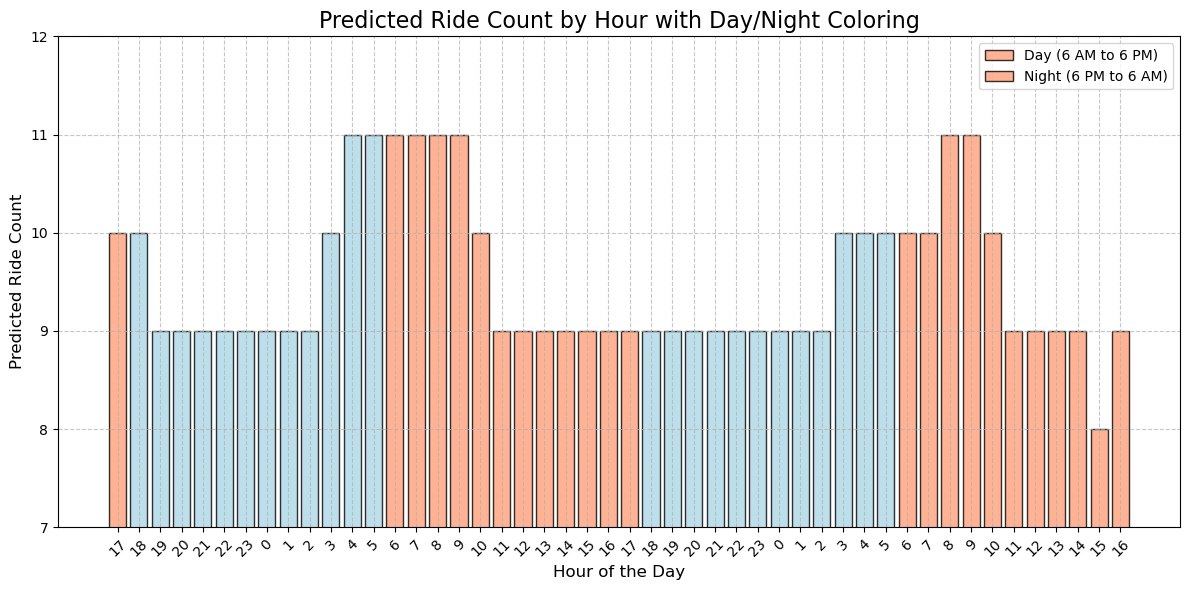

In [8]:
# Extract the start hour from the forecasted data
start_hour = prediction_series["Datetime"].iloc[0].hour

# Assign sequential hours using the index instead of iteration
prediction_series["Hour"] = (start_hour + prediction_series.index) % 24

# Assign colors based on day or night
colors = ["lightsalmon" if hour in range(6, 18) else "lightblue" for hour in prediction_series["Hour"]]

# Plot the histogram with corrected hours as the x-axis
plt.figure(figsize=(12, 6))
bars = plt.bar(
    range(len(prediction_series)),  # Use a simple range for x positions
    prediction_series["Predicted Ride Count"], 
    color=colors, 
    edgecolor="black", 
    alpha=0.8
)

# Add titles and labels
plt.title("Predicted Ride Count by Hour with Day/Night Coloring", fontsize=16)
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Predicted Ride Count", fontsize=12)

# Set x-ticks to match the actual hours of the day
plt.xticks(
    ticks=range(len(prediction_series)), 
    labels=prediction_series["Hour"], 
    rotation=45  # Rotate labels for better readability
)

# Set the y-axis limit to start one unit below the lowest value
plt.ylim(prediction_series["Predicted Ride Count"].min() - 1, prediction_series["Predicted Ride Count"].max() + 1)

# Set Grid
plt.grid(visible=True, linestyle="--", alpha=0.7)

# Add legend
plt.legend(
    [bars[0], bars[-1]], 
    ["Day (6 AM to 6 PM)", "Night (6 PM to 6 AM)"], 
    loc="upper right"
)

# Show the plot
plt.tight_layout()
plt.show()
